In [27]:
import numpy as np
import time
import torch
import torchvision.models as models
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

from dataset import FacialImageData
from custom_transforms import ImgMask


In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## Load Data

In [10]:
## create Transform
train_transform = transforms.Compose(
    [
        transforms.RandomCrop(48, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(
            (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
        )
    ]
)

val_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
        )
    ]
)
## create dataset
data_dir = "./data"
train_set = FacialImageData(
    directory=data_dir + "/train",
    transform=train_transform
)
val_set = FacialImageData(
    directory=data_dir + "/test",
    transform=val_transform
)
## create dataloader
## dataloaders automatically sample from dataset
TRAIN_BATCH_SIZE = 128
VAL_BATCH_SIZE = 100
train_loader = DataLoader(
    train_set,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=8
)
val_loader = DataLoader(
    val_set,
    batch_size=VAL_BATCH_SIZE,
    shuffle=False,
    num_workers=8
)

## Build Model

In [11]:
## define model
resnet50 = models.resnet50(pretrained=True)
num_classes = 7 ## how many classes in fer?
resnet50.fc = torch.nn.Linear(resnet50.fc.in_features, num_classes)

d:\L\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\L\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\GLi81/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:13<00:00, 7.71MB/s]


In [12]:
## define hyperparameters

LR = 0.01
MOMENTUM = 0.9
REG = 1e-4
NUM_EPOCH = 30

## Learning rate decay
LR_DECAY = 0.1
DECAY_EPOCH = 5

In [13]:
## create optimizer
optimizer = optim.SGD(
    resnet50.parameters(),
    lr=LR,
    momentum=MOMENTUM,
    weight_decay=REG
)
## create loss function
loss_func = nn.CrossEntropyLoss().to(device)

# the folder where the trained model is saved
CHECKPOINT_FOLDER = "./saved_model"
best_val_acc = 0
resnet50 = resnet50.to(device)
current_learning_rate = LR

## Initial Loss
#########################################################################
resnet50.eval()
# this help you compute the validation accuracy
total_examples = 0
correct_examples = 0
val_loss = 0 # again, track the validation loss if you want
# disable gradient during validation, which can save GPU memory
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(val_loader):
        # copy inputs to device
        inputs = inputs.to(device)
        targets = targets.to(device)
        # compute the output and loss
        out = resnet50(inputs)
        loss = loss_func(out, targets)
        # count the number of correctly predicted samples in the current batch
        _, predicted = torch.max(out, 1)
        correct = predicted.eq(targets).sum()
        val_loss += loss.detach().cpu()
        total_examples += targets.shape[0]
        correct_examples += correct.item()
avg_loss = val_loss / len(val_loader)
avg_acc = correct_examples / total_examples
print("Initial loss: %.4f, Initial accuracy: %.4f" % (avg_loss, avg_acc))
#########################################################################
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []
# start the training/validation process
print("==> Training starts!")
print("="*50)
for i in range(0, NUM_EPOCH):
    print("Epoch %d:" %i)
    ## Train on the train set
    #####################################################################
    # switch to train mode
    resnet50.train()
    # this help you compute the training accuracy
    total_examples = 0
    correct_examples = 0
    train_loss = 0 # track training loss if you want
    # Train the model for 1 epoch.
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # copy inputs to device
        inputs = inputs.to(device)
        targets = targets.to(device)
        # compute the output and loss
        out = resnet50(inputs)
        loss = loss_func(out, targets)
        # zero the gradient
        optimizer.zero_grad()
        # backpropagation
        loss.backward()
        # apply gradient and update the weights
        optimizer.step()
        # count the number of correctly predicted samples in the current batch
        _, predicted = torch.max(out, 1)
        correct = predicted.eq(targets).sum()
        train_loss += loss.detach().cpu()
        total_examples += targets.shape[0]
        correct_examples += correct.item()
    avg_loss = train_loss / len(train_loader)
    train_loss_hist.append(avg_loss)
    avg_acc = correct_examples / total_examples
    train_acc_hist.append(avg_acc)
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))
    ######################################################################

    # Validate on the validation dataset
    ######################################################################
    # switch to eval mode
    resnet50.eval()
    # this help you compute the validation accuracy
    total_examples = 0
    correct_examples = 0
    val_loss = 0 # track the validation loss
    # disable gradient during validation, which can save GPU memory
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            # copy inputs to device
            inputs = inputs.to(device)
            targets = targets.to(device)
            # compute the output and loss
            out = resnet50(inputs)
            loss = loss_func(out, targets)
            # count the number of correctly predicted samples
            # in the current batch
            _, predicted = torch.max(out, 1)
            correct = predicted.eq(targets).sum()
            val_loss += loss.detach().cpu()
            total_examples += targets.shape[0]
            correct_examples += correct.item()
    avg_loss = val_loss / len(val_loader)
    test_loss_hist.append(avg_loss)
    avg_acc = correct_examples / total_examples
    test_acc_hist.append(avg_acc)
    print(
        "Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc)
    )
    ######################################################################

    # save the model checkpoint
    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        if not os.path.exists(CHECKPOINT_FOLDER):
           os.makedirs(CHECKPOINT_FOLDER)
        print("Saving ...")
        state = {'state_dict': resnet50.state_dict(),
                'epoch': i,
                'lr': current_learning_rate}
        torch.save(state, os.path.join(CHECKPOINT_FOLDER, 'resnet50_on_FER.pth'))
    print('')
    ## decay learning rate
    if i % DECAY_EPOCH == 0 and i != 0:
        current_learning_rate *= LR_DECAY
        for param_group in optimizer.param_groups:
            param_group["lr"] = current_learning_rate
            print(f"Current learning rate has decayed to %f" %current_learning_rate)

print("="*50)
print(
    f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}"
)

Initial loss: 2.1760, Initial accuracy: 0.1271
==> Training starts!
Epoch 0:
Training loss: 1.4109, Training accuracy: 0.4614
Validation loss: 1.2396, Validation accuracy: 0.5350
Saving ...

Epoch 1:
Training loss: 1.1454, Training accuracy: 0.5628
Validation loss: 1.0898, Validation accuracy: 0.5798
Saving ...

Epoch 2:
Training loss: 1.0489, Training accuracy: 0.6026
Validation loss: 1.0921, Validation accuracy: 0.5904
Saving ...

Epoch 3:
Training loss: 0.9879, Training accuracy: 0.6281
Validation loss: 1.0421, Validation accuracy: 0.6158
Saving ...

Epoch 4:
Training loss: 0.9457, Training accuracy: 0.6453
Validation loss: 1.0352, Validation accuracy: 0.6145

Epoch 5:
Training loss: 0.9084, Training accuracy: 0.6608
Validation loss: 1.0424, Validation accuracy: 0.6127

Current learning rate has decayed to 0.001000
Epoch 6:
Training loss: 0.7977, Training accuracy: 0.7042
Validation loss: 0.9507, Validation accuracy: 0.6528
Saving ...

Epoch 7:
Training loss: 0.7568, Training accura

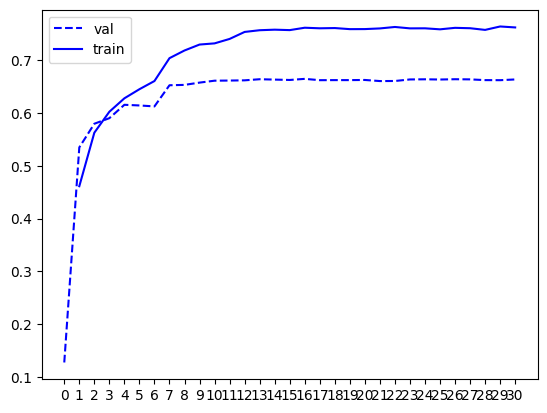

In [14]:
val_plot = [0.1271]
train_plot = train_acc_hist[:]
val_plot.extend(test_acc_hist[:])
## plots
import matplotlib.pyplot as plt
plt.plot(range(len(val_plot)), val_plot, "b--", label="val")
plt.plot(range(1, len(train_plot) + 1), train_plot, 'b', label="train")
plt.xticks(np.arange(0, max(len(train_plot) + 1, len(val_plot)), 1.0))
plt.legend()
plt.show()

In [15]:
train_loss_hist

[tensor(1.4109),
 tensor(1.1454),
 tensor(1.0489),
 tensor(0.9879),
 tensor(0.9457),
 tensor(0.9084),
 tensor(0.7977),
 tensor(0.7568),
 tensor(0.7343),
 tensor(0.7192),
 tensor(0.6959),
 tensor(0.6682),
 tensor(0.6627),
 tensor(0.6563),
 tensor(0.6560),
 tensor(0.6500),
 tensor(0.6489),
 tensor(0.6456),
 tensor(0.6486),
 tensor(0.6479),
 tensor(0.6476),
 tensor(0.6459),
 tensor(0.6495),
 tensor(0.6446),
 tensor(0.6445),
 tensor(0.6439),
 tensor(0.6438),
 tensor(0.6497),
 tensor(0.6470),
 tensor(0.6452)]

In [16]:
train_acc_hist

[0.46135358250026126,
 0.5628200215960152,
 0.6025984882789369,
 0.628060886829914,
 0.6453028666968547,
 0.660838064718381,
 0.7042042565049288,
 0.7187641506147898,
 0.7300149778815006,
 0.7322442439653071,
 0.7406736563447003,
 0.7539447559998607,
 0.757184158277892,
 0.7582291267546762,
 0.7573931519732489,
 0.7619213487059807,
 0.7608415479466369,
 0.7612943676199101,
 0.7592392629489011,
 0.7593437597965794,
 0.7605977219687207,
 0.7633494722909192,
 0.760702218816399,
 0.7608067156640774,
 0.7588909401233063,
 0.7617123550106238,
 0.7609808770768749,
 0.7578111393639625,
 0.764289943920025,
 0.7624786652269323]

In [17]:
test_loss_hist

[tensor(1.2396),
 tensor(1.0898),
 tensor(1.0921),
 tensor(1.0421),
 tensor(1.0352),
 tensor(1.0424),
 tensor(0.9507),
 tensor(0.9481),
 tensor(0.9520),
 tensor(0.9588),
 tensor(0.9658),
 tensor(0.9603),
 tensor(0.9617),
 tensor(0.9644),
 tensor(0.9664),
 tensor(0.9731),
 tensor(0.9607),
 tensor(0.9696),
 tensor(0.9643),
 tensor(0.9663),
 tensor(0.9710),
 tensor(0.9691),
 tensor(0.9680),
 tensor(0.9663),
 tensor(0.9661),
 tensor(0.9653),
 tensor(0.9663),
 tensor(0.9623),
 tensor(0.9691),
 tensor(0.9684)]

In [18]:
test_acc_hist

[0.53496795764837,
 0.5798272499303427,
 0.5904151574254667,
 0.6157704095848425,
 0.6145165784341042,
 0.6127054889941488,
 0.6528280858177765,
 0.6535246586792979,
 0.65784341042073,
 0.6614655893006408,
 0.6617442184452493,
 0.6621621621621622,
 0.6642518807467261,
 0.6635553078852048,
 0.6628587350236835,
 0.6649484536082474,
 0.6624407913067707,
 0.6625801058790749,
 0.6625801058790749,
 0.6628587350236835,
 0.6607690164391196,
 0.6609083310114238,
 0.6638339370298133,
 0.6641125661744218,
 0.6636946224575091,
 0.6642518807467261,
 0.6639732516021176,
 0.6625801058790749,
 0.6624407913067707,
 0.6638339370298133]